# <center> Coding Discussion 04

### <center> <font color='gray'>by Rahul Shrivastava</font> 

Loading in the required libraries and setting up the environment.

In [5]:
import pandas as pd
import numpy as np
import pprint as pp # for printing
import scipy.stats as st # for Normal PDF

# Plotting libraries 
import matplotlib.pyplot as plt
import seaborn as sns
from plotnine import *

# Silence warnings 
import warnings
warnings.filterwarnings("ignore")

In [7]:
# Reading in the csv files
turnout = pd.read_csv(r"Data\turnout.csv")
turnout.head()

,id,age,educate,income,vote,white
0,1,60,14.0,3.3458,1,1
1,2,51,10.0,1.8561,0,1
2,3,24,12.0,0.6304,0,1
3,4,38,8.0,3.4183,1,1
4,5,25,12.0,2.7852,1,1


In [8]:
# Set seed
np.random.seed(1234)

# Train-Test split (just using Pandas)
train = turnout.sample(frac=.8).reset_index(drop=True)
test = turnout.drop(train.index).reset_index(drop=True)

# Print off the split count 
print("Training Data:",train.shape[0],
      "\nTest Data:",test.shape[0])

# Look at the head of the data
train.head()

Training Data: 1600 
Test Data: 400


,id,age,educate,income,vote,white
0,1749,78,16.0,1.3131,1,1
1,935,72,3.0,0.6765,1,0
2,1034,64,10.0,1.3131,1,1
3,244,80,8.0,1.1839,1,1
4,929,19,14.0,2.9072,1,1


In [9]:
N = train.shape[0]

# Subset the data by class
vt1 = train.query("vote == 1")
vt0 = train.query("vote == 0")

# Calculate the probability for each class
pr_vt_1 = vt1.shape[0]/N
pr_vt_0 = vt0.shape[0]/N

# Print the probabilities
print(
f"""
Pr(voter_turnout = 1): {pr_vt_1}
Pr(voter_turnout = 0): {pr_vt_0}
""")


Pr(voter_turnout = 1): 0.7425
Pr(voter_turnout = 0): 0.2575



In [10]:
# Given voted
w1_vt1 = vt1.query("white == 1").shape[0]/vt1.shape[0]
w0_vt1 = vt1.query("white == 0").shape[0]/vt1.shape[0]

# Given not voted
w1_vt0 = vt0.query("white == 1").shape[0]/vt0.shape[0]
w0_vt0 = vt0.query("white == 0").shape[0]/vt0.shape[0]

print(
f"""
Pr(white = 1 |voted = 1): {w1_vt1}
Pr(white = 0 |voted = 1): {w0_vt1}
Pr(white = 1 |voted = 0): {w1_vt0}
Pr(white = 0 |voted = 0): {w0_vt0}
""")


Pr(white = 1 |voted = 1): 0.8686868686868687
Pr(white = 0 |voted = 1): 0.13131313131313133
Pr(white = 1 |voted = 0): 0.7985436893203883
Pr(white = 0 |voted = 0): 0.20145631067961164



### Making a sample prediction
Making a prediction on whether a person will vote **given they are white**.

In [11]:
prob_vt1 = w1_vt1 * pr_vt_1
prob_vt0 = w1_vt0 * pr_vt_0

print(f"""
Pr(vt = 1) = {prob_vt1}
Pr(vt = 0) = {prob_vt0}
""")


Pr(vt = 1) = 0.6450000000000001
Pr(vt = 0) = 0.205625



In this case we can see the probablilty of a person voting when they are white is 0.645 which is greater than 0.206, here we can predict that the person will vote **(vt = 1)**.

### Predictions for Multiple Observations

In [12]:
# Remove Variables that are not required

train_disc = train.drop(columns=['id', 'age', 'educate', 'income'])
test_disc = test.drop(columns=['id', 'age', 'educate', 'income'])

In [15]:
def calc_probs(data,outcome_var=""):
    '''
    Function calculates the class and conditional probabilities in 
    the binary data. 
    
    Note that I'm using dictionaries with tuple keys to keep
    track of the variable, it's val, and the outcome, which we're conditioning on. 
    '''
    # Generate empty dictionary containers.
    class_probs = {};cond_probs = {}
    # Locate all variables that are not the outcome.
    vars = [v for v in data.columns if v != outcome_var]
    # iterate through the class outcomes
    for y, d in data.groupby(outcome_var): 
        # calculate the class probabilities
        class_probs.update({y: d.shape[0]/data.shape[0]})
        for v in vars:
            # calculate the conditional probabilities for each variable given the class.
            pr = d[v].sum()/d.shape[0]
            cond_probs[(v,1,y)] = pr 
            cond_probs[(v,0,y)] = 1 - pr
    return class_probs, cond_probs


# Run
class_probs, cond_probs = calc_probs(train_disc,outcome_var="vote")

# Print
print("class probabilities",end="\n\n")
pp.pprint(class_probs)
print("\n")
print("conditional probabilities",end="\n\n")
pp.pprint(cond_probs)

class probabilities

{0: 0.2575, 1: 0.7425}


conditional probabilities

{('white', 0, 0): 0.20145631067961167,
 ('white', 0, 1): 0.13131313131313127,
 ('white', 1, 0): 0.7985436893203883,
 ('white', 1, 1): 0.8686868686868687}


In [16]:
# Building a funciton to iterate throgh the data and calculate probability of outcome to make predictions for each observation and selects the class.

def predict(data,class_probs,cond_probs):
    '''
    Function calculates the conditional probability for membership into each class.
    Then returns both the probabilities and the most likely class. 
    '''
    store_preds = []
    for i,row in data.iterrows():
        pr_1 = 1; pr_0 = 1
        for j in range(1,len(row.index)):
            pr_0 *= cond_probs[(row.index[j],row.values[j],0)]
            pr_1 *= cond_probs[(row.index[j],row.values[j],1)]     
        pr_0 *= class_probs[0]
        pr_1 *= class_probs[1]
        store_preds.append([pr_0,pr_1,max([(pr_0,0),(pr_1,1)])[1]])
    return pd.DataFrame(store_preds,columns=["pr_0","pr_1","pred"])

# Run 
preds = predict(train_disc, class_probs, cond_probs)
preds.head()

,pr_0,pr_1,pred
0,0.205625,0.6450,1
1,0.051875,0.0975,1
2,0.205625,0.6450,1
3,0.205625,0.6450,1
4,0.205625,0.6450,1


Now we can assess the accuracy of the model for training data

In [17]:
accuracy = sum(train_disc.vote == preds.pred)/train.shape[0]
accuracy

0.7425

Accuracy of the training data is at 74% - this is decent. Now let's assess the accuracy of the model for the test data:

In [19]:
test_preds = predict(test_disc, class_probs, cond_probs)
test_accuracy = sum(test_disc.vote == test_preds.pred)/test.shape[0]
test_accuracy

0.7

The Test data gives us an accuracy of 70%.

## Naive Bayesian Classification for Continuous Variables in the Data

In [21]:
# Remove Variables that are not required and re-structure data

train_cont = train.drop(columns=['id', 'white', 'age'])
train_cont = train_cont[['vote', 'educate', 'income']]
train_cont.columns = ['y', 'x1', 'x2']


test_cont = test.drop(columns=['id', 'white', 'age'])
test_cont = test_cont[['vote', 'educate', 'income']]
test_cont.columns = ['y', 'x1', 'x2']

In [20]:
st.norm(0, 1).pdf(-1.69) # using the scipy.stats module

0.09565679616352402

### Calculate Probabilities

In [22]:
y1 = train_cont.query("y == 1")
y0 = train_cont.query("y == 0")

# Class probabilities.
pr_y1 = y1.shape[0]/train_cont.shape[0]
pr_y0 = y0.shape[0]/train_cont.shape[0]

Calculating the conditional mean/standard deviations

In [23]:
# Collect the mean and standard dev. of each conditional distribution
dist_locs = \
{("x1",1):{'mean':y1.x1.mean(),'sd':y1.x1.std()},
 ("x1",0):{'mean':y0.x1.mean(),'sd':y0.x1.std()},
 ("x2",1):{'mean':y1.x2.mean(),'sd':y1.x2.std()},
 ("x2",0):{'mean':y0.x2.mean(),'sd':y0.x2.std()}
}

# Print
pp.pprint(dist_locs)

{('x1', 0): {'mean': 10.62864077669903, 'sd': 3.304381091983527},
 ('x1', 1): {'mean': 12.558922558922559, 'sd': 3.295714127444309},
 ('x2', 0): {'mean': 2.7381618932038836, 'sd': 2.2429913729337625},
 ('x2', 1): {'mean': 4.229461952861947, 'sd': 2.8482089910676964}}


Graphing these conditional means

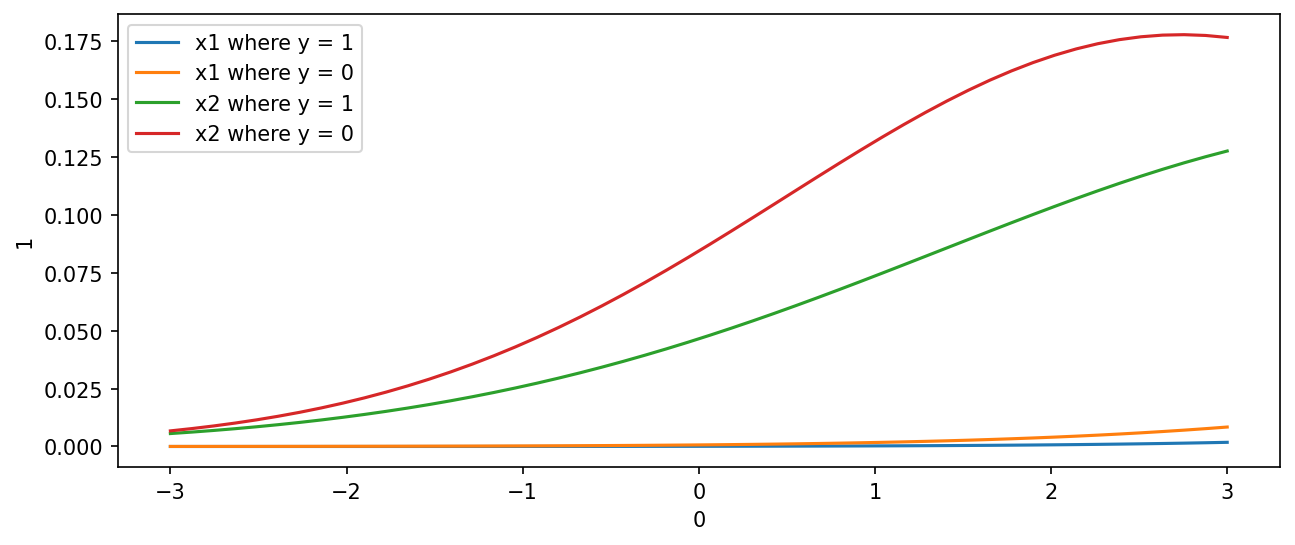

In [24]:
# Plot with seaborn
plt.figure(figsize=(10,4),dpi=150)
for key in dist_locs.keys():
    locs = dist_locs[key]
    d = pd.DataFrame([[i,st.norm(locs['mean'], locs['sd']).pdf(i)] 
                      for i in np.linspace(-3,3)])
    ax = sns.lineplot(d[0],d[1],label=f"{key[0]} where y = {key[1]}")

### Making Predictions

In [26]:
y,x1,x2 = train_cont.iloc[1,:]
print(y,x1,x2)

1.0 3.0 0.6765


In [27]:
# Prediction for the 1 class
a = st.norm(dist_locs[("x1",1)]['mean'], dist_locs[("x1",1)]['sd']).pdf(x1)
b = st.norm(dist_locs[("x2",1)]['mean'], dist_locs[("x2",1)]['sd']).pdf(x2)
c = pr_y1
pr_1 = a * b * c

# Prediction for the 0 class
a = st.norm(dist_locs[("x1",0)]['mean'], dist_locs[("x1",0)]['sd']).pdf(x1)
b = st.norm(dist_locs[("x2",0)]['mean'], dist_locs[("x2",0)]['sd']).pdf(x2)
c = pr_y0
pr_0 = a * b * c

print(
f'''
    Pr(y == 1| X): {pr_1}
    Pr(y == 0| X): {pr_0}
''')


    Pr(y == 1| X): 8.617228592896047e-05
    Pr(y == 0| X): 0.00025226846729919694



Prediction y == 1 is 8.61 against the prediction of y == 0 of 0.00025, the first prediction is much bigger so we predict that the outcome for this observation is y == 1, i.e. the person will vote.

### Predictions For the Data

In [28]:
def predict(data,dist_locs):
    ''''''
    store_preds = []
    for i,row in data.iterrows():
        
        # Get the predictions using a Gaussan distribution
        pr_0 = 1; pr_1 = 1
        for j in range(1,len(row)):
            pr_0 *= st.norm(dist_locs[(row.index[j],0)]['mean'],
                            dist_locs[(row.index[j],0)]['sd']).pdf(row.values[j])
            pr_1 *= st.norm(dist_locs[(row.index[j],1)]['mean'], 
                            dist_locs[(row.index[j],1)]['sd']).pdf(row.values[j])
        pr_0 *= pr_y0
        pr_1 *= pr_y1
        
        # Assign the class designation to the highest probability
        if pr_0 >= pr_1:
            class_pred = 0
        else:
            class_pred = 1
            
        store_preds.append([pr_0,pr_1,class_pred])
        
    return pd.DataFrame(store_preds,columns=["pr_0","pr_1","pred"])

# Run
preds_train = predict(train_cont,dist_locs)

In [45]:
# Predicted output
preds_train.head(10)

,pr_0,pr_1,pred
0,0.001206,0.004321,1
1,0.000252,0.000086,0
2,0.004438,0.005513,1
3,0.003170,0.002730,0
4,0.003276,0.010273,1
5,0.000466,0.000190,0
6,0.004891,0.009462,1
7,0.001431,0.006917,1
8,0.002290,0.004604,1
9,0.002755,0.011423,1


Checking the accuracy of the model

In [30]:
accuracy_train = sum(train_cont.y == preds_train.pred)/train_cont.shape[0]
accuracy_train

0.73125

We have an accuracy of 73% for the training data. Let's check the accuracy for test data:

In [31]:
preds_test = predict(test_cont,dist_locs)

In [32]:
accuracy_test = sum(test_cont.y == preds_test.pred)/test_cont.shape[0]
accuracy_test

0.7075

**We have an accuracy of 70% for the test data which is better than a coin flip and therefore this model is relatively reliable, however it could be improved.**

### Confusion Matrix Using sklearn

In [33]:
# Organize our data real quick so it plugs into the sklearn API easily 
train_y = train_cont['y']
train_x = train_cont[['x1','x2']]
test_y = test_cont['y']
test_x = test_cont[['x1','x2']]

In [34]:
from sklearn.naive_bayes import GaussianNB # Classifier 
import sklearn.metrics as m # Metrics to determine the classification 

# Instantiate the model class
gnb = GaussianNB()
gnb.fit(train_x, train_y) # Train

# Predict 
y_pred = gnb.predict(test_x)

# Out-of-sample performance 
m.accuracy_score(test_y,y_pred)

0.705

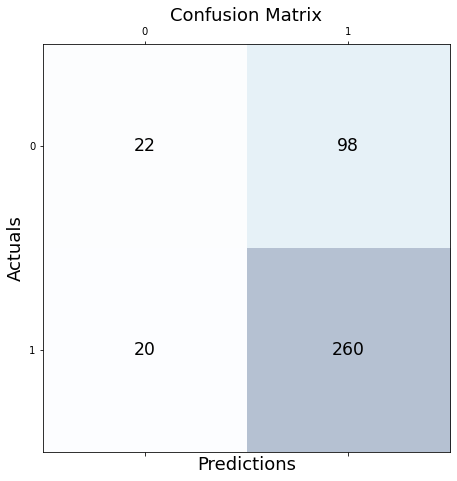

In [56]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import make_pipeline

# Creating a confusion matrix
conf_matrix = m.confusion_matrix(test_y, y_pred)

# Print the confusion matrix using Matplotlib

fig, ax = plt.subplots(figsize=(7.5, 7.5))
ax.matshow(conf_matrix, cmap=plt.cm.Blues, alpha=0.3)
for i in range(conf_matrix.shape[0]):
    for j in range(conf_matrix.shape[1]):
        ax.text(x=j, y=i,s=conf_matrix[i, j], va='center', ha='center', size='xx-large')
 
plt.xlabel('Predictions', fontsize=18)
plt.ylabel('Actuals', fontsize=18)
plt.title('Confusion Matrix', fontsize=18)
plt.show()

Our Sklearn model give us the following Metrics:
    <br>Accuracy: 70.5%
    <br>Precision: 72.6%
    <br>Specifity: 18.33%
    <br>Recall: 92.85%
    
Here we can see that the model does not have the best Specificity and this can be problematic when our key consideration is getting the negative predictions right.